In [6]:
#!pip install trackpy
from __future__ import division, unicode_literals, print_function  
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import trackpy as tp
from scipy import ndimage  # for shifting images
from scipy.interpolate import griddata  # for resampling
import matplotlib.patches as mpatches   # circles
from scipy.signal import savgol_filter
from skimage.transform import rotate
from scipy.optimize import curve_fit
#This Cell Imports all the necessary modules

In [7]:
#master dataframe(for representing tabular data like a spreadsheet does?)
m_df = [] #Creates an empty list
m_df.append([])#Adds a list to a list(nested list)
m_df.append([])
#load all the data into the one dataframe
num = 9 #number of trials
trial_offset = 0 #last trial number we are skipping. trial_offset=9 means the first trial we load is #10
for i in range(num):#loop nine times in this case. 
    m_df[0].append(pd.read_csv("t"+str(i+trial_offset+1)+"c.csv")) #"close" arrays in 0 spot
    m_df[1].append(pd.read_csv("t"+str(i+trial_offset+1)+"f.csv")) #"far" arrays in 1 spot


C:\Users\lobrient\AppData\Local\Temp\ipykernel_12432\2883011810.py:9: DtypeWarning: Columns (0,1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  m_df[0].append(pd.read_csv("t"+str(i+trial_offset+1)+"c.csv")) #"close" arrays in 0 spot
C:\Users\lobrient\AppData\Local\Temp\ipykernel_12432\2883011810.py:10: DtypeWarning: Columns (0,1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  m_df[1].append(pd.read_csv("t"+str(i+trial_offset+1)+"f.csv")) #"far" arrays in 1 spot
C:\Users\lobrient\AppData\Local\Temp\ipykernel_12432\2883011810.py:9: DtypeWarning: Columns (0,1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  m_df[0].append(pd.read_csv("t"+str(i+trial_offset+1)+"c.csv")) #"close" arrays in 0 spot
C:\Users\lobrient\AppData\Local\Temp\ipykernel_12432\2883011810.py:10: DtypeWarning: Columns (0,1,2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memor

In [8]:
#load timing array
time = np.array(m_df[0][0].loc[1:,"Time"])#fetches out the time column from our dataframe
size = len(time)#length of the time list
for i in range(size):# for loop used for converting to float values
    time[i] = float(time[i])#loop for converting to float values
#create master voltage array
m_v_ar = np.zeros((num, 2, 2, 3, size)) #trial, downrange/uprange, close/far, x/y/z, data
#load data into the master array. Array of the voltages was created. 
#switch letter order because x is on B/F, y is on A/E. First list is downrange, second is uprange
col_names = [["Channel B", "Channel A", "Channel C"], ["Channel F", "Channel E", "Channel G"]] 
for trial in range(num):# for each of the three trials. downrange or uprange. 
    for du in range(2): #du is short for downrange/uprange
        for cf in range(2): #cf is short for close/far. Basically we are considering both of the two cases of close and far and downrange and uprange. 
            for xyz in range(3):
                m_v_ar[trial,du,cf,xyz,:] = np.array(m_df[cf][trial].loc[1:,col_names[du][xyz]])
                #here values are assigned to indices in the voltage array. 

In [9]:
#Acceleration integrator
def find_baseline(channel):
    sum = 0
    for i in range(10000):
        sum += channel[i]
    return sum/10000

conv = 1

def integrate_accel(channel, Time):
    baseline = find_baseline(channel)
    velocity = np.zeros(Time.size)
    running_sum = 0
    for i in range(Time.size-1):
        dv = 0.5*(conv*(channel[i]-baseline)+(channel[i+1]-baseline))*(Time[i+1]-Time[i])
        running_sum += dv
        velocity[i] = running_sum
    velocity[i+1] = running_sum
    return velocity

def sub_integrate_vel(channel, lower, higher, Time):
    baseline = find_baseline(channel)
    velocity = np.zeros(Time.size)
    running_sum = 0
    for i in range(lower, higher):
        dv = 0.5*((channel[i]-baseline)+(channel[i+1]-baseline))*(Time[i+1]-Time[i])
        running_sum += dv
        velocity[i] = running_sum
    velocity[i+1] = running_sum
    return velocity

def differentiate(data, f_p_s):
    dx = np.zeros(data.size)
    for i in range(dx.size-1):
        dx[i] = (data[i+1]-data[i])*f_p_s
    return dx

In [10]:
#Have to convert the voltage array to acceleration. In trials 1-9 the close accelerometers are 16 g while far are 3 g
#3g has .30 Volts/g, 16 g has .057 volts/g

scales = np.array([0.057, 0.3]) #volts/g for 16g (close), 3g (far) accelerometers. Conversion values stored in this array. 

#Finding the baseline of each array
voltage_baselines = np.zeros((num, 2, 2, 3)) #trial, downrange/uprange, close/far, x/y/z. Empty array with dimensions defined. 
for i in range(num): #for each trial. 
    for j in range(2): #for downrange/uprange
        for k in range(2): #for close/far
            for l in range(3): #for x/y/z
                voltage_baselines[i,j,k,l] = find_baseline(m_v_ar[i,j,k,l,:]) #storing each baseline. Creating an array of baselines. 

#master acceleration array (in m/s/s)
m_ac_ar = np.zeros((num,2,2,3,size))
for i in range(num): #for each trial
    for j in range(2): #for downrange/uprange
        for k in range(2): #for close/far
            for l in range(3): #for x/y/z
                m_ac_ar[i,j,k,l,:] = (m_v_ar[i,j,k,l,:]-voltage_baselines[i,j,k,l])/scales[k]*9.81

In [11]:
#find the integration start index
int_start = np.zeros((num,2,2,3))
threshold = 0.005 #volts
for i in range(num): #for each trial
    for j in range(2): #for downrange/uprange
        for k in range(2): #for close/far
            for l in range(3): #for x/y/z
                int_start[i,j,k,l] = np.argmax((m_v_ar[i,j,k,l,:]-voltage_baselines[i,j,k,l])>threshold)-100

In [12]:
def onset_time(v):
    m=np.argmax(v)
    ind=m-100
    onset=time[ind]
    return ind, onset
m_ve_ar = np.zeros((9,2,2,3,size))

b,a=onset_time(m_ve_ar[0,0,0,0,:])
d,c=onset_time(m_ve_ar[1,0,0,0,:])
f,e=onset_time(m_ve_ar[2,0,0,0,:])
h,g=onset_time(m_ve_ar[3,0,0,0,:])
j,i=onset_time(m_ve_ar[4,0,0,0,:])
l,k=onset_time(m_ve_ar[5,0,0,0,:])
m,n=onset_time(m_ve_ar[6,0,0,0,:])


In [13]:
time1=np.zeros(100004)
time2=np.zeros(100004)
time3=np.zeros(100004)
time4=np.zeros(100004)
time5=np.zeros(100004)
time6=np.zeros(100004)
time7=np.zeros(100004)
time8=np.zeros(100004)
time9=np.zeros(100004)

for i in range(100004):
        time1[i]=time[i]-(838.2874761/1000)
        time2[i]=time[i]-(872.6042711/1000)
        time3[i]=time[i]-(865.5812991/1000)
        time4[i]=time[i]-(831.1048911/1000)
        time5[i]=time[i]-(831.2645041/1000)
        time6[i]=time[i]-(826.4761141/1000)
        time7[i]=time[i]-(867.0178161/1000)
        time8[i]=time[i]-(836.0528941/1000)
        time9[i]=time[i]-(842.1181881/1000)


In [14]:
times=[time1,time2,time3,time4,time5,time6,time7,time8,time9]
#master velocity array (in m/s)
velocity_sum=np.zeros((9,3,size))
for i in range(9): #for each trial
    for j in range(2): #for downrange/uprange
        for k in range(2): #for close/far
            for l in range(3): #for x/y/z
                start = int_start[i,j,k,0]
                m_ve_ar[i,j,k,l,:] = sub_integrate_vel(m_ac_ar[i,j,k,l,:],int(start),int(start+1000),times[i])
                velocity_sum[i,l]+=(m_ve_ar[i,j,k,l,:])
velocity_sum=(velocity_sum[0]-velocity_sum[6])+(velocity_sum[2]-velocity_sum[4])+(velocity_sum[1]-velocity_sum[3])+(velocity_sum[8]+velocity_sum[7])+velocity_sum[5]


In [15]:
m=(m_ve_ar[0,0,0,0:]-m_ve_ar[6,0,0,0:])+(m_ve_ar[2,0,0,0:]-m_ve_ar[4,0,0,0:])+(m_ve_ar[2,0,0,0:]-m_ve_ar[4,0,0,0:])



(0.75, 0.9)

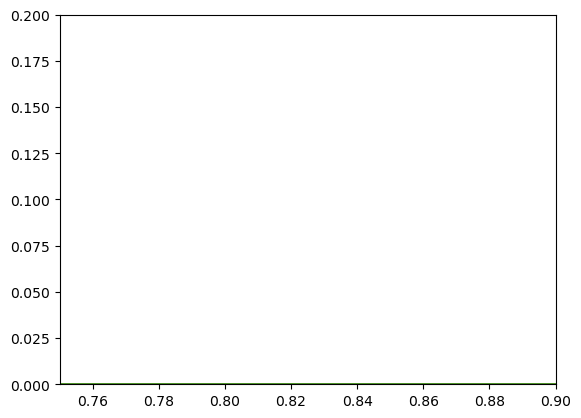

In [16]:
for j in range(3):
    plt.plot(time,abs(velocity_sum[j,:]))
plt.ylim(0,0.2)
plt.xlim(0.75,0.9)


In [17]:
#finding peaks
peak_ac = np.zeros((num,2,2,3))
peak_vel = np.zeros((num,2,2,3))
for i in range(num): #for each trial
    for j in range(2): #for downrange/uprange
        for k in range(2): #for close/far
            for l in range(3): #for x/y/z
                a_ind = np.argmax(m_ac_ar[i,j,k,l,:]**2)
                v_ind = np.argmax(m_ve_ar[i,j,k,l,:]**2)
                peak_ac[i,j,k,l] = m_ac_ar[i,j,k,l,a_ind]
                peak_vel[i,j,k,l] = m_ve_ar[i,j,k,l,v_ind]

In [18]:
#Define positions array for the position of each accelerometer
pos = np.zeros((num,3)) #trial number, depth/close_distance/far_distance
#values for trials 10-18
depths = [5,7,3]
close_pos = [6,8,7]
far_pos = [10,12,11]
for i in range(3):
    for j in range(3):
        pos[i,0] = depths[i]
        pos[i,1] = close_pos[j]
        pos[i,2] = far_pos[j]

In [19]:
pos

array([[ 5.,  7., 11.],
       [ 7.,  7., 11.],
       [ 3.,  7., 11.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [20]:
abs_peak_ac = np.zeros((num,2,2))
abs_peak_vel = np.zeros((num,2,2))
for i in range(num):
    for j in range(2):
        for k in range(2):
            abs_peak_ac[i,j,k] = (peak_ac[i,j,k,0]**2+peak_ac[i,j,k,1]**2+peak_ac[i,j,k,2]**2)**0.5
            abs_peak_vel[i,j,k] = (peak_vel[i,j,k,0]**2+peak_vel[i,j,k,1]**2+peak_vel[i,j,k,2]**2)**0.5

In [21]:
np.save('velocity_1_9.npy', abs_peak_vel)
np.save('accel_1_9.npy', abs_peak_ac)
np.save('time_1_9.npy', time)

np.save('velocitycomp_1_9.npy', peak_vel)
np.save('accel_1_9comp.npy', peak_ac)


Text(0.5, 0, 'radial (cylindrical) distance from crater center (cm)')

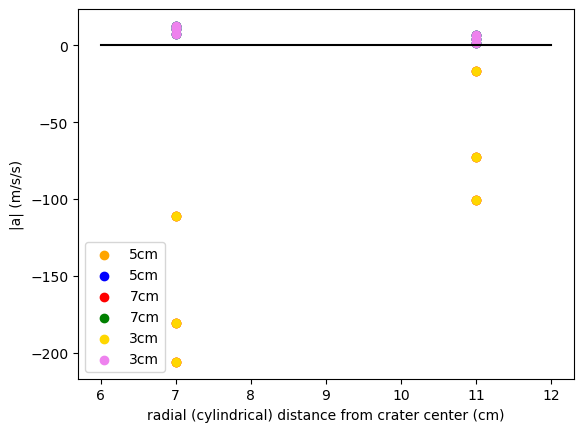

In [22]:
cs = [ ["ORANGE","BLUE"], ["RED","GREEN"], ["GOLD","VIOLET"]] #depths go 5cm, 7cm, 3cm
depths = ["5cm", "7cm", "3cm"]
for dep in range(3): #3 different depths
    for i in range(3): #trial index (doing groups of 3 at the same depth)
        for j in range(2): #close/far
            for k in range(2): #downrange/uprange
                if(i==0 and j==0):
                    plt.scatter(pos[i,j+1],(-1)**(k+1)*abs_peak_ac[i,j,k], color=cs[dep][k], label=depths[dep])
                else:
                    plt.scatter(pos[i,j+1],(-1)**(k+1)*abs_peak_ac[i,j,k], color=cs[dep][k])
plt.plot([6,12],[0,0],color="BLACK")
plt.legend() #dep*3+i
plt.ylabel("|a| (m/s/s)")
plt.xlabel("radial (cylindrical) distance from crater center (cm)")

(-0.1, 0.025)

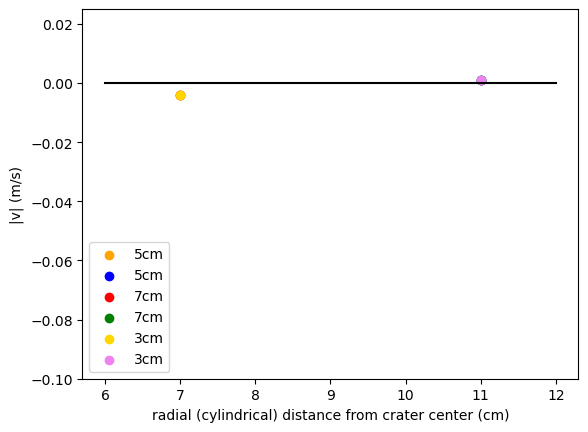

In [23]:
#look at depth of 5 cm
cs = [ ["ORANGE","BLUE"], ["RED","GREEN"], ["GOLD","VIOLET"]] #depths go 5cm, 7cm, 3cm
depths = ["5cm", "7cm", "3cm"]
for dep in range(3): #3 different depths
    for i in range(3): #trial index (doing groups of 3 at the same depth)
        for j in range(2): #close/far
            for k in range(2): #downrange/uprange
                if(i==0 and j==0):
                    plt.scatter(pos[i,j+1],(-1)**(k+1)*abs_peak_vel[i,j,k], color=cs[dep][k], label=depths[dep])
                else:
                    plt.scatter(pos[i,j+1],(-1)**(k+1)*abs_peak_vel[i,j,k], color=cs[dep][k])
plt.plot([6,12],[0,0],color="BLACK")
plt.legend()
plt.ylabel("|v| (m/s)")
plt.xlabel("radial (cylindrical) distance from crater center (cm)")
plt.ylim(-0.1,0.025)

In [24]:
m_ac_ar.shape

(9, 2, 2, 3, 100004)

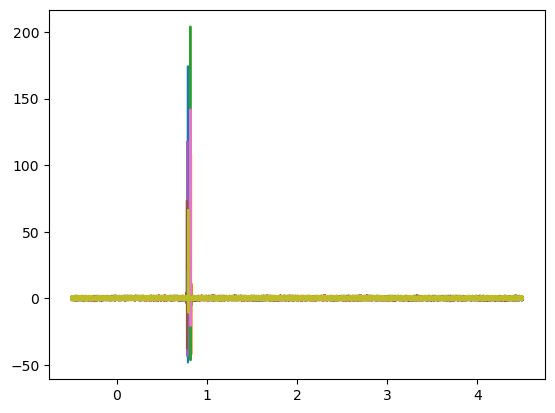

In [25]:
for i in range(num):
    plt.plot(time,m_ac_ar[i,0,0,0,:])#aha this is in gs not in m/s/s

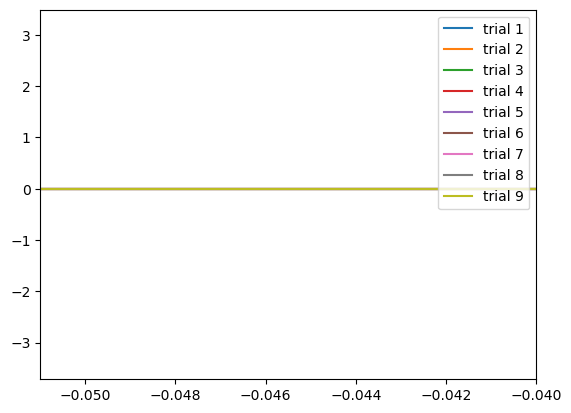

In [26]:
#for i in range(num):
plt.plot(time1,m_ve_ar[0,0,0,0,:], label='trial 1')
plt.plot(time2,m_ve_ar[1,0,0,0,:], label='trial 2')
plt.plot(time3,m_ve_ar[2,0,0,0,:], label='trial 3')
plt.plot(time4,m_ve_ar[3,0,0,0,:], label='trial 4')
plt.plot(time5,m_ve_ar[4,0,0,0,:], label='trial 5')
plt.plot(time6,m_ve_ar[5,0,0,0,:], label='trial 6')
plt.plot(time7,m_ve_ar[6,0,0,0,:], label='trial 7')
plt.plot(time8,m_ve_ar[7,0,0,0,:], label='trial 8')
plt.plot(time9,m_ve_ar[8,0,0,0,:], label='trial 9')



#plt.ylim(-0.1,0.1)
plt.xlim(-0.051,-0.04)

plt.legend(loc='upper right')